In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, roc_curve, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

from joblib import Parallel, delayed

import time



# Dataset file loading

The file loaded here is the preprocessed .csv file downloaded at the end of Data Prepping & EDA.ipynb file.

In [5]:
df = pd.read_csv('heart_disease_cleaned_new.csv')

print(df.head())

   State  Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0     42    2              4                  30                 0   
1     15    2              2                   0                 3   
2     41    2              2                   0                 0   
3      3    1              2                   0                 0   
4     44    2              3                   0                 0   

   LastCheckupTime  PhysicalActivities  SleepHours  RemovedTeeth  HadAsthma  \
0                1                   1           6             4          1   
1                1                   1           8             4          2   
2                1                   1           6             1          2   
3                1                   1           6             1          2   
4                1                   2           8             4          2   

   ...  WeightInKilograms     BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  \
0  ...             0.907

# Data Extraction and Train/Test data split


In [18]:
df.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos', 'Heart Disease'],
      dtype='object')

In [6]:
df['Heart Disease'].value_counts()

,count
Heart Disease,
0,28027
1,21616


In [7]:
# Define the feature matrix and the target variable
X = df.drop(columns='Heart Disease')
y = df['Heart Disease']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

# Defining methods to be used

## Grid Search for identifying best hyperparameters for models.
Returns the best hyperparameters and best model for each model that is deployed.

In [12]:
def grid_search(X,y, param_grid, model):
  # Perform Grid Search with cross-validation
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
  grid_search.fit(X_train, y_train)

  # Best parameters found by GridSearchCV
  print("Best Parameters:", grid_search.best_params_)

  # Use the best estimator to make predictions on the test set
  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_

  return best_model, best_params

## Particle Swarm Optimisation with Tuning
Encompasses the randomsearch method to the Particle Swarm Optimization algorithm

In [10]:
# UPDATED
# Particle class
class Particle:
    def __init__(self, num_features):
        self.position = np.random.uniform(0, 1, num_features)  # Random initial position
        self.velocity = np.random.uniform(low=-1, high=1, size=num_features)  # Random initial velocity
        self.best_position = self.position.copy()  # Initial best position
        self.best_score = -np.inf  # Initial best score (accuracy or negative error)

# Function for mini-batch sampling
def get_mini_batch(X, y, batch_size):
    idx = np.random.choice(X.shape[0], batch_size, replace=False)
    if isinstance(X, np.ndarray):
        return X[idx], y[idx]
    else:  # For pandas DataFrame
        return X.iloc[idx], y.iloc[idx]

# Fitness function with mini-batching and feature selection
def fitness_function(X_batch, y_batch, particle, best_params, model_type='svm', threshold=0.5):
    # Select features based on particle position and threshold
    selected_features = np.where(particle.position > threshold)[0]
    if len(selected_features) == 0:
        return -np.inf

    # Use selected features to train classifier or regressor
    X_batch_selected = X_batch[:, selected_features] if isinstance(X_batch, np.ndarray) else X_batch.iloc[:, selected_features]

    if model_type == 'svm':
        clf = SVC(kernel=best_params['kernel'], random_state=42, class_weight="balanced",C=best_params['C'], gamma=best_params['gamma'])
        clf.fit(X_batch_selected, y_batch)
        score = clf.score(X_batch_selected, y_batch)  # Use accuracy
    elif model_type == 'random_forest':
        clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], random_state=42, class_weight="balanced", min_samples_leaf=best_params['min_samples_leaf'],
                                    bootstrap=best_params['bootstrap'], max_depth=best_params['max_depth'], max_features=best_params['max_features'], min_samples_split= best_params['min_samples_split'])
        clf.fit(X_batch_selected, y_batch)
        score = clf.score(X_batch_selected, y_batch)  # Use accuracy
    elif model_type == 'logistic_regression':
        clf = LogisticRegression(solver=best_params_logreg['solver'],C=best_params['C'], penalty=best_params['penalty'], class_weight=best_params['class_weight'])
        clf.fit(X_batch_selected, y_batch)
        score = clf.score(X_batch_selected, y_batch)
    elif model_type == 'xgboost':
        print('sucess')
        print(best_params)
        clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators= best_params['n_estimators'], max_depth = best_params['max_depth'], learning_rate=best_params['learning_rate'],
                            min_child_weight= best_params['min_child_weight'], subsample =best_params['subsample'], colsample_bytree = best_params['colsample_bytree'], gamma= best_params['gamma'], reg_alpha= best_params['reg_alpha'],
                            reg_lambda= best_params['reg_lambda'])
        clf.fit(X_batch_selected, y_batch)
        score = clf.score(X_batch_selected, y_batch)  # Use accuracy
    else:
        raise ValueError("Unsupported model type. Choose from 'svm', 'random_forest', 'logistic_regression', or 'xgboost'.")

    return score

# Random Search for PSO hyperparameters
def random_search_pso(X, y, best_params_model, model_type='svm', search_iterations=10):
    # Parameter ranges for random search
    param_space = {
        'num_particles': (10, 50),     # Number of particles range
        'num_iterations': (50, 100),   # Number of iterations range
        'inertia_weight': (0.5, 1.0),  # Inertia weight range
        'personal_coeff': (1.5, 2.5),  # Cognitive coefficient range
        'social_coeff': (1.5, 2.5),    # Social coefficient range
        'threshold': (0.3, 0.7),       # Threshold for feature selection range
        'batch_size': (64, 256)        # Batch size range
    }

    # Global variables to keep track of best overall solution
    global_best_position = None
    global_best_score = -np.inf
    best_params = {}

    # Loop over search_iterations to try different hyperparameters
    for search_iteration in range(search_iterations):
        # Randomly sample hyperparameters from defined ranges
        num_particles = np.random.randint(*param_space['num_particles'])
        num_iterations =np.random.randint(*param_space['num_iterations'])
        inertia_weight = np.random.uniform(*param_space['inertia_weight'])
        personal_coeff = np.random.uniform(*param_space['personal_coeff'])
        social_coeff = np.random.uniform(*param_space['social_coeff'])
        threshold = np.random.uniform(*param_space['threshold'])
        batch_size = np.random.randint(*param_space['batch_size'])

        # Run PSO with sampled hyperparameters
        print(f"Search Iteration {search_iteration+1}/{search_iterations} with params: num_particles={num_particles}, "
              f"num_iterations={num_iterations}, inertia_weight={inertia_weight}, personal_coeff={personal_coeff}, "
              f"social_coeff={social_coeff}, threshold={threshold}, batch_size={batch_size}")

        # Perform PSO optimization
        best_position, best_score = particle_swarm_optimization(X, y, model_type, num_particles, num_iterations,
                                                                inertia_weight, personal_coeff, social_coeff, best_params_model,
                                                                threshold, batch_size)

        # Update global best solution if found
        if best_score > global_best_score:
            global_best_score = best_score
            global_best_position = best_position
            best_params = {
                'num_particles': num_particles,
                'num_iterations': num_iterations,
                'inertia_weight': inertia_weight,
                'personal_coeff': personal_coeff,
                'social_coeff': social_coeff,
                'threshold': threshold,
                'batch_size': batch_size
            }

    return global_best_position, global_best_score, best_params

# PSO algorithm modified for random search of parameters
def particle_swarm_optimization(X, y, model_type, num_particles, num_iterations, inertia_weight, personal_coeff, social_coeff, best_params, threshold=0.5, batch_size=128):
    num_features = X.shape[1]
    particles = [Particle(num_features) for _ in range(num_particles)]
    global_best_position = None
    global_best_score = -np.inf

    print(type(num_iterations))
    for iteration in range(int(num_iterations)):
        # Mini-batching
        X_batch, y_batch = get_mini_batch(X, y, batch_size)

        # Evaluate particles in parallel
        fitness_values = Parallel(n_jobs=-1)(delayed(fitness_function)(X_batch, y_batch, particle, best_params, model_type, threshold) for particle in particles)

        # Update each particle's best score and global best score
        for i, particle in enumerate(particles):
            fitness = fitness_values[i]
            if fitness > particle.best_score:
                particle.best_score = fitness
                particle.best_position = particle.position.copy()
            if fitness > global_best_score:
                global_best_score = fitness
                global_best_position = particle.position.copy()

        # Update particle velocities and positions using sampled hyperparameters
        for particle in particles:
            r1, r2 = np.random.rand(2)  # Random factors
            cognitive = personal_coeff * r1 * (particle.best_position - particle.position)
            social = social_coeff * r2 * (global_best_position - particle.position)
            particle.velocity = inertia_weight * particle.velocity + cognitive + social
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, 0, 1)  # Keep position within [0, 1] bounds

    return global_best_position, global_best_score


## Evaluation Metrics
Below are two methods that are used to measure the performance of the models implementing the above dataset. (AUC-ROC, Sensitivity and Specificity Threshold graphs)

In [9]:
def roc_auc(model, X_test, y_test, text):
  # Get predicted probabilities for each class (class 0 and class 1)
  y_probs = model.predict_proba(X_test)

  # Calculate ROC curve for class 1 (positive class)
  fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_probs[:, 1], pos_label=1)
  auc_1 = roc_auc_score(y_test, y_probs[:, 1])

  # Calculate ROC curve for class 0 (negative class)
  fpr_0, tpr_0, thresholds_0 = roc_curve(y_test, y_probs[:, 0], pos_label=0)
  auc_0 = roc_auc_score(1 - y_test, y_probs[:, 0])  # For class 0, flip y_test

  # Plot ROC curves
  plt.figure(figsize=(10, 6))

  # Plot ROC for class 1
  plt.plot(fpr_1, tpr_1, color='blue', label=f'Class 1 (Positive) (AUC = {auc_1:.2f})')
  # Plot ROC for class 0
  plt.plot(fpr_0, tpr_0, color='green', label=f'Class 0 (Negative) (AUC = {auc_0:.2f})')

  # Random guessing line
  plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

  # Labels and title
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for Each Class in "+text)
  plt.legend(loc="lower right")
  plt.show()

In [8]:
def analyze_thresholds(model, X_test, y_test, text):
    """
    This function calculates and plots the sensitivity and specificity for various thresholds.

    Parameters:
    - model: Trained machine learning model that can predict probabilities.
    - X_test: Test features.
    - y_test: True labels for the test set.

    Returns:
    - A plot of sensitivity and specificity across a range of thresholds.
    - A DataFrame containing thresholds, sensitivity, and specificity.
    """
    # Predict probabilities
    probabilities = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)

    # Calculate True Negative Rate (Specificity)
    tnr = 1 - fpr

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr, label='Sensitivity')
    plt.plot(thresholds, tnr, label='Specificity')
    plt.title('Sensitivity and Specificity for Various Thresholds in '+text)
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create DataFrame to return
    import pandas as pd
    threshold_frame = pd.DataFrame({
        'Threshold': thresholds,
        'Sensitivity': tpr,
        'Specificity': tnr
    })

    return threshold_frame

# Model Implementation
# 1 Random Forest

## 1.1 Standalone Random Forest

In [ ]:
# Initializing the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight="balanced")
bl_rf_model=BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)
bl_rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_bl=bl_rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print("========================================")
accuracy_bl= accuracy_score(y_test, y_pred_bl)
print(f'Accuracy: {accuracy_bl:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_bl))

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      5606
           1       0.72      0.74      0.73      4323

    accuracy                           0.76      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.76      0.76      0.76      9929

Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      5606
           1       0.69      0.81      0.74      4323

    accuracy                           0.76      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.77      0.76      0.76      9929



In [ ]:
# Get the predicted probabilities for the positive class
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Adjust the threshold (e.g., 0.3 instead of 0.5)
threshold = 0.3
y_pred_threshold_rf = (y_pred_proba_rf >= threshold).astype(int)
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_threshold_rf)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_threshold_rf))

Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      5606
           1       0.62      0.92      0.74      4323

    accuracy                           0.72      9929
   macro avg       0.76      0.74      0.72      9929
weighted avg       0.78      0.72      0.72      9929



In [ ]:
# Getting feature importance from the trained Random Forest
feature_importance_i_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_i_rf)

                      Feature  Importance
26                AgeCategory    0.124549
29                        BMI    0.072363
2               GeneralHealth    0.065799
0                       State    0.065063
24                  ChestScan    0.064763
28          WeightInKilograms    0.064557
27             HeightInMeters    0.053031
7                  SleepHours    0.036889
3          PhysicalHealthDays    0.035402
8                RemovedTeeth    0.034004
33              PneumoVaxEver    0.032883
4            MentalHealthDays    0.026540
15                HadDiabetes    0.026222
34          TetanusLast10Tdap    0.025876
19          DifficultyWalking    0.023473
22               SmokerStatus    0.022161
14               HadArthritis    0.021818
1                         Sex    0.017219
25      RaceEthnicityCategory    0.015426
36                   CovidPos    0.014890
30            AlcoholDrinkers    0.013558
5             LastCheckupTime    0.013081
11                    HadCOPD    0

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
330 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
Test AUC: 0.8431810981410238
Test Accuracy: 0.7654345855574579


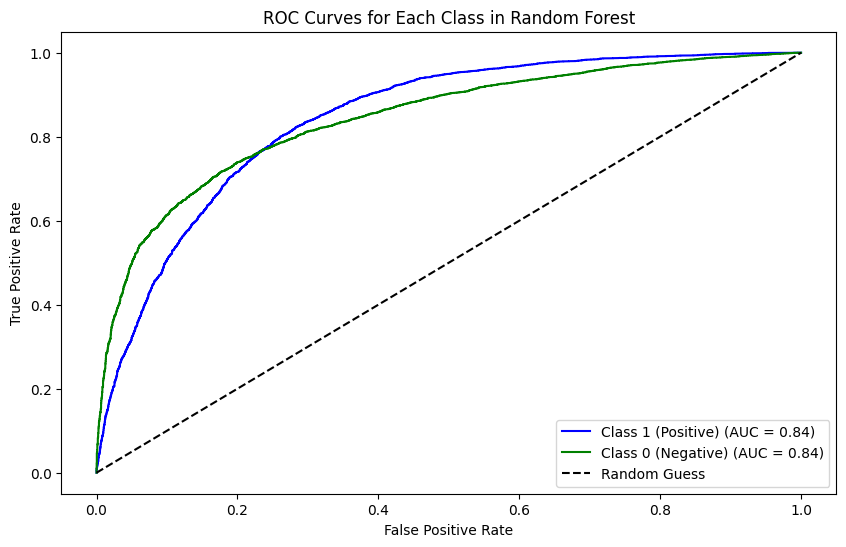

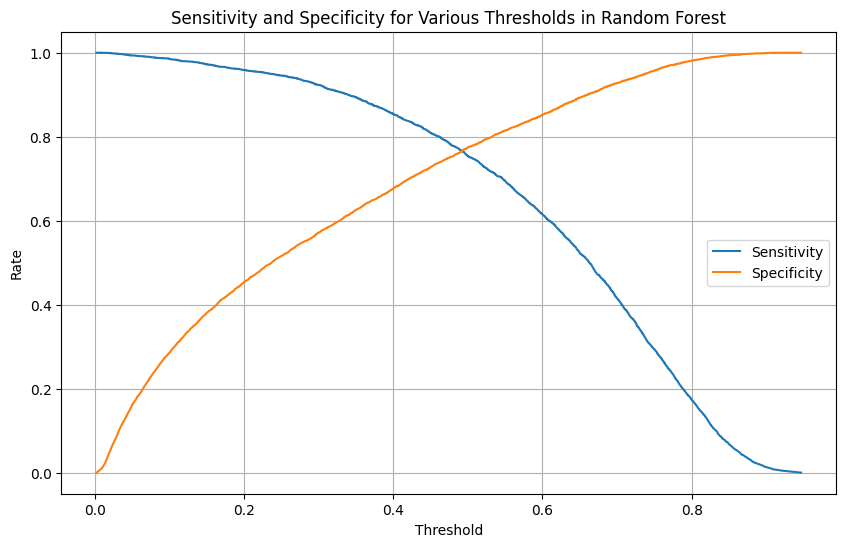


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      5606
           1       0.72      0.75      0.74      4323

    accuracy                           0.77      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.77      0.77      0.77      9929

Time elapsed: 4906.74 seconds


In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 250,],  # Number of trees
    'max_depth': [None, 10, 50],  # Max depth of the tree
    'min_samples_split': [10, 100],  # Min samples required to split
    'min_samples_leaf': [1, 2, 4],  # Min samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

best_rf, best_params_rf=grid_search(X_train,y_train,param_grid,rf)
predictions_rf = best_rf.predict(X_test)

# Check the performance of the model
print("Test AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))

print("Test Accuracy:", accuracy_score(y_test, predictions_rf))
roc_auc(best_rf, X_test, y_test,'Random Forest')
analyze_thresholds(best_rf, X_test, y_test, 'Random Forest')

print('\nClassification Report:')
print(classification_report(y_test, predictions_rf))

# Start the timer
start_time_rf_grid = time.time()

rf_model = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'], random_state=42, class_weight="balanced", min_samples_leaf=best_params_rf['min_samples_leaf'],
                                    bootstrap=best_params_rf['bootstrap'], max_depth=best_params_rf['max_depth'], max_features=best_params_rf['max_features'], min_samples_split= best_params_rf['min_samples_split'])
rf_model.fit(X_train,y_train)

# End the timer
end_time_rf_grid = time.time()

# Calculate the elapsed time
elapsed_time_rf = end_time_rf_grid - start_time_rf_grid
print(f"Time elapsed: {elapsed_time_rf:.2f} seconds")

                      Feature  Importance
26                AgeCategory    0.154692
24                  ChestScan    0.102413
2               GeneralHealth    0.085641
29                        BMI    0.053321
28          WeightInKilograms    0.047645
0                       State    0.045757
33              PneumoVaxEver    0.043449
8                RemovedTeeth    0.039971
19          DifficultyWalking    0.038343
27             HeightInMeters    0.037500
3          PhysicalHealthDays    0.035621
15                HadDiabetes    0.034179
14               HadArthritis    0.027304
7                  SleepHours    0.023606
1                         Sex    0.023159
4            MentalHealthDays    0.019822
22               SmokerStatus    0.019138
34          TetanusLast10Tdap    0.018719
11                    HadCOPD    0.017229
5             LastCheckupTime    0.013369
13           HadKidneyDisease    0.012117
30            AlcoholDrinkers    0.010909
16        DeafOrHardOfHearing    0

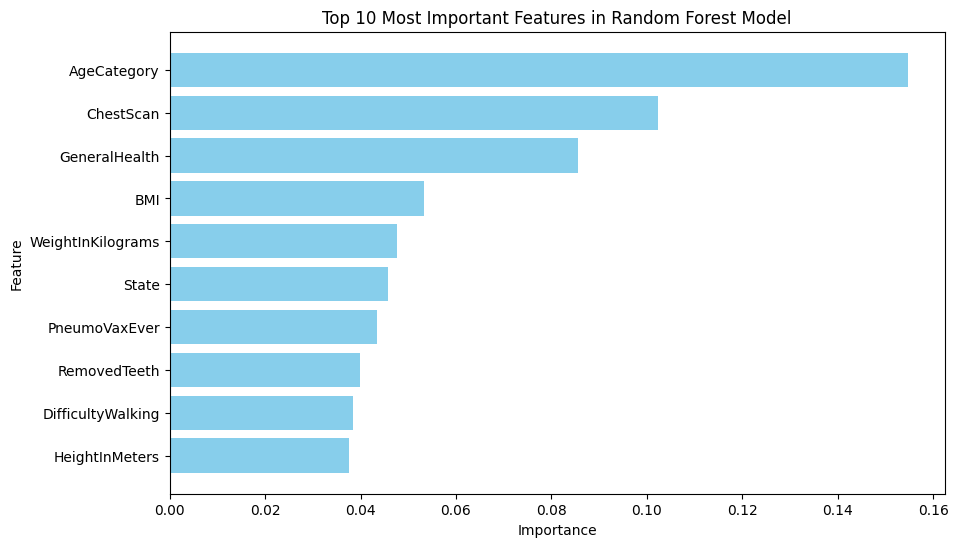

In [ ]:
# Getting feature importance from the trained Random Forest
feature_importance_i_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_i_rf)

top_features = feature_importance_i_rf.head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

## 1.2 Random Forest with PSO

Search Iteration 1/10 with params: num_particles=19, num_iterations=70, inertia_weight=0.8502867356792938, personal_coeff=1.6683238007289982, social_coeff=2.23213578917588, threshold=0.47968160675503, batch_size=137
<class 'int'>
Search Iteration 2/10 with params: num_particles=16, num_iterations=87, inertia_weight=0.7443545375311837, personal_coeff=1.997765110019422, social_coeff=2.145645299738204, threshold=0.6652356231260342, batch_size=128
<class 'int'>
Search Iteration 3/10 with params: num_particles=13, num_iterations=65, inertia_weight=0.772592867485091, personal_coeff=2.432401023438095, social_coeff=2.307422237791993, threshold=0.6893135412877582, batch_size=181
<class 'int'>
Search Iteration 4/10 with params: num_particles=15, num_iterations=78, inertia_weight=0.8416012527994348, personal_coeff=1.6123682182530552, social_coeff=2.1223874392692395, threshold=0.4497684335648538, batch_size=102
<class 'int'>
Search Iteration 5/10 with params: num_particles=11, num_iterations=73, i

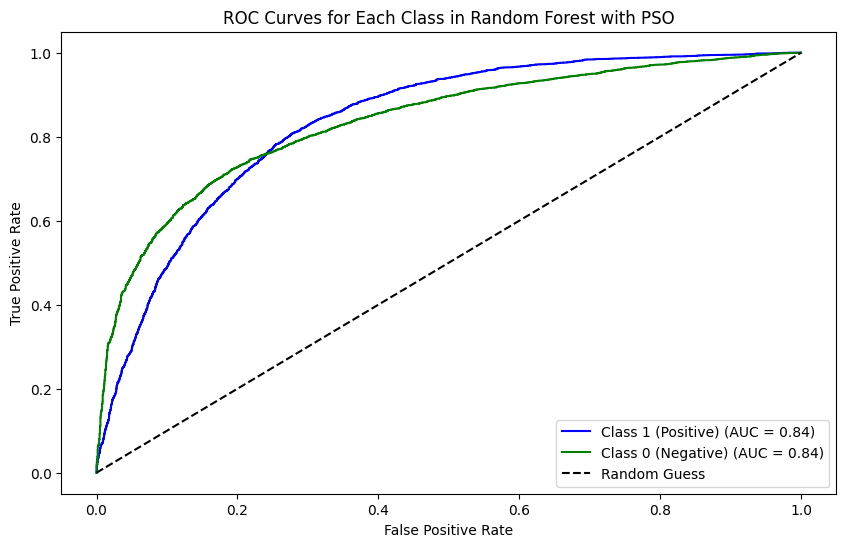

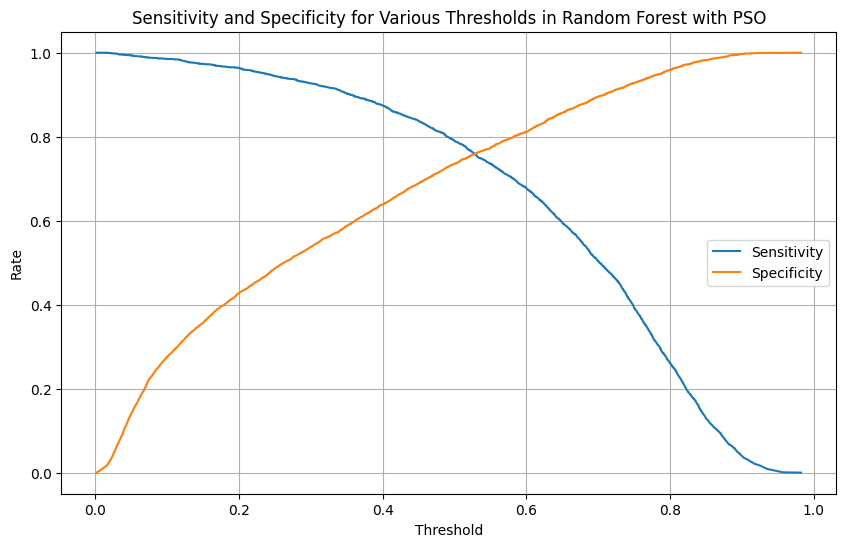

Time elapsed: 1069.70 seconds


In [ ]:
#best_params_rf= {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}

best_position, best_score, best_params = random_search_pso(X_train, y_train, best_params_rf, model_type="random_forest", search_iterations=10)
print("==============================================================================")
print("Best PSO position:", best_position)
print("Best PSO score:", best_score)
print("Best PSO parameters:", best_params)
print("==============================================================================")

best_features, best_score = particle_swarm_optimization(X_train, y_train, 'random_forest', best_params['num_particles'],best_params['num_iterations'], best_params['inertia_weight'], best_params['personal_coeff'],best_params['social_coeff'],best_params_rf, best_params['threshold'], best_params['batch_size'] )

print("==============================================================================")
print(f"Best feature subset: {np.where(best_features >=0.5)[0]}")
print(f"Best score: {best_score}")

X_FS_tuned=X_train.iloc[:,np.where(best_features >= 0.5)[0]]
X_test_FS_tuned=X_test.iloc[:,np.where(best_features >= 0.5)[0]]
print(X_FS_tuned.columns)
print(X_FS_tuned.head())
print("==============================================================================")


# Start the timer
start_time_rf_PSO = time.time()

# Initialize the RandomForestClassifier
#best_params_rf
rf_model_PSO = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'], random_state=42, class_weight="balanced", min_samples_leaf=best_params_rf['min_samples_leaf'],
                                    bootstrap=best_params_rf['bootstrap'], max_depth=best_params_rf['max_depth'], max_features=best_params_rf['max_features'], min_samples_split= best_params_rf['min_samples_split'])

# Train the model
rf_model_PSO.fit(X_FS_tuned, y_train)

# End the timer
end_time_rf_PSO = time.time()

# Make predictions on the test set
y_pred_rf_PSO = rf_model_PSO.predict(X_test_FS_tuned)

# Evaluate the model
accuracy_rf_PSO = accuracy_score(y_test, y_pred_rf_PSO)
print("==============================================================================")
#print(f'Accuracy: {accuracy_rf_PSO:.2f}')
# Check the performance of the model
print("Test Accuracy:", accuracy_score(y_test,y_pred_rf_PSO))
print("Test AUC:", roc_auc_score(y_test, rf_model_PSO.predict_proba(X_test_FS_tuned)[:, 1]))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf_PSO))

roc_auc(rf_model_PSO, X_test_FS_tuned, y_test, 'Random Forest with PSO')
analyze_thresholds(rf_model_PSO, X_test_FS_tuned, y_test, 'Random Forest with PSO')

# Calculate the elapsed time
elapsed_time_rf_PSO = end_time_rf_PSO - start_time_rf_PSO
print(f"Time elapsed: {elapsed_time_rf_PSO:.2f} seconds")

                      Feature  Importance
13                AgeCategory    0.243432
12                  ChestScan    0.130465
2               GeneralHealth    0.109659
15                        BMI    0.084806
14          WeightInKilograms    0.073967
0                       State    0.072071
3          PhysicalHealthDays    0.050708
8           DifficultyWalking    0.048516
7                 HadDiabetes    0.045862
1                         Sex    0.028998
17          TetanusLast10Tdap    0.026221
16               FluVaxLast12    0.015539
4          PhysicalActivities    0.013653
19                   CovidPos    0.012497
11            ECigaretteUsage    0.011683
6       HadDepressiveDisorder    0.009567
10          DifficultyErrands    0.008367
5                   HadAsthma    0.007881
9   DifficultyDressingBathing    0.004357
18           HighRiskLastYear    0.001750


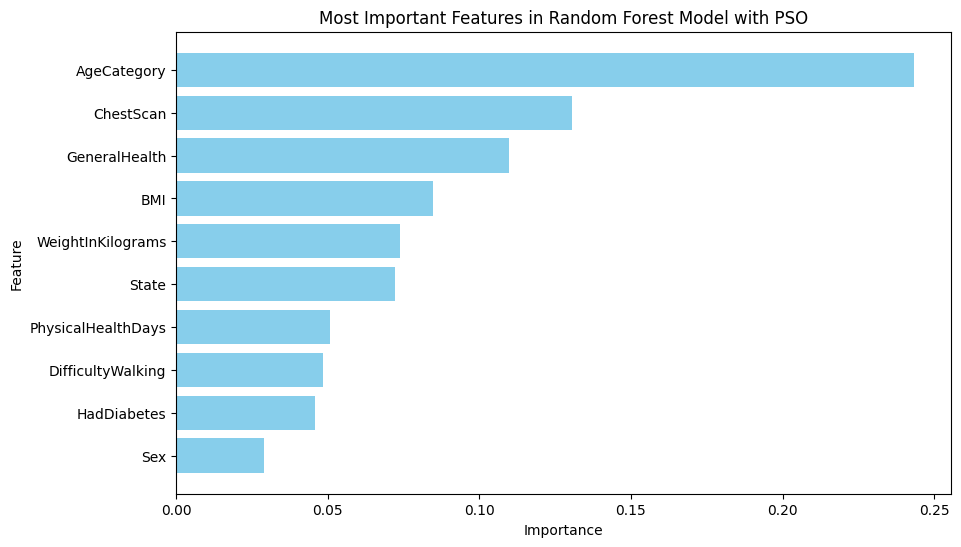

In [ ]:
# Get feature importance from the trained Random Forest
feature_importance_rf_PSO = pd.DataFrame({
    'Feature': X_FS_tuned.columns,
    'Importance': rf_model_PSO.feature_importances_
}).sort_values(by='Importance', ascending=False)


print(feature_importance_rf_PSO)
top_features = feature_importance_rf_PSO.head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features in Random Forest Model with PSO')
plt.gca().invert_yaxis()
plt.show()

#2 XGBoost

## 2.1 Standalone XGBoost

Fitting 3 folds for each of 512 candidates, totalling 1536 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:53:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.7658374458656461
Test AUC: 0.8454306995190128


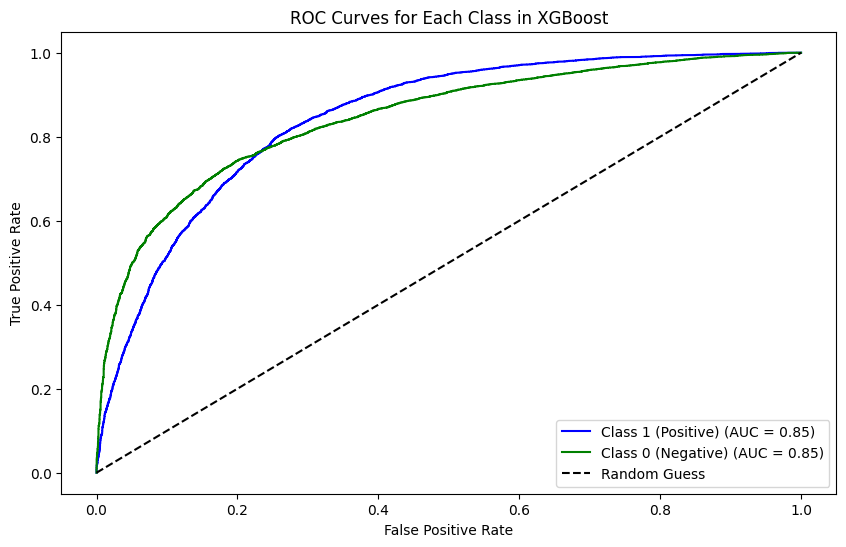

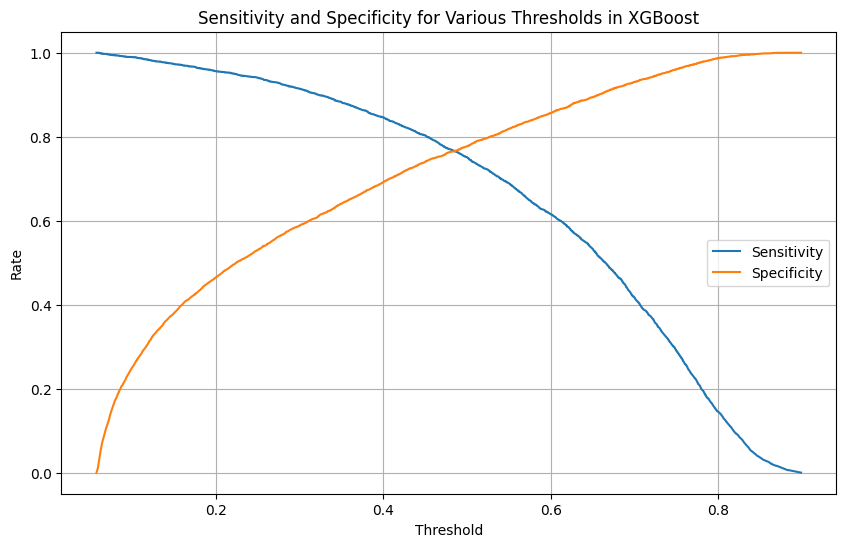


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      5606
           1       0.72      0.75      0.74      4323

    accuracy                           0.77      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.77      0.77      0.77      9929

Time elapsed: 706.09 seconds


In [ ]:
# XGBClassifier initialization
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Defining the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [100, 250],          # Number of boosting rounds
    'max_depth': [10, 50],         # Max depth of a tree
    'learning_rate': [0.01, 0.1],   # Learning rate
    'min_child_weight': [1, 3],       # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 1.0],             # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],      # Subsample ratio of columns when constructing each tree
    'gamma': [0.1, 0.5],              # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0.1, 1],            # L1 regularization term on weights
    'reg_lambda': [1, 2]            # L2 regularization term on weights
}

# GridSearch
best_xgb,best_params_xgb = grid_search(X_train,y_train,param_grid, xgb)

# Making predictions
predictions_xgb = best_xgb.predict(X_test)

# Outputing the performance of the model
print("Test Accuracy:", accuracy_score(y_test, predictions_xgb))
print("Test AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))
roc_auc(best_xgb, X_test, y_test, 'XGBoost')
analyze_thresholds(best_xgb, X_test, y_test, 'XGBoost')
print('\nClassification Report:')
print(classification_report(y_test, predictions_xgb))

# Start the timer
start_time_xgb_grid = time.time()

xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators= best_params_xgb['n_estimators'], max_depth = best_params_xgb['max_depth'], learning_rate=best_params_xgb['learning_rate'],
                            min_child_weight= best_params_xgb['min_child_weight'], subsample =best_params_xgb['subsample'], colsample_bytree = best_params_xgb['colsample_bytree'], gamma= best_params_xgb['gamma'], reg_alpha= best_params_xgb['reg_alpha'],
                            reg_lambda= best_params_xgb['reg_lambda'])
xgboost.fit(X_train,y_train)

# Ending the timer
end_time_xgb_grid = time.time()

# Calculating the elapsed time
elapsed_time_xgb_grid = end_time_xgb_grid - start_time_xgb_grid
print(f"Time elapsed: {elapsed_time_xgb_grid:.2f} seconds")

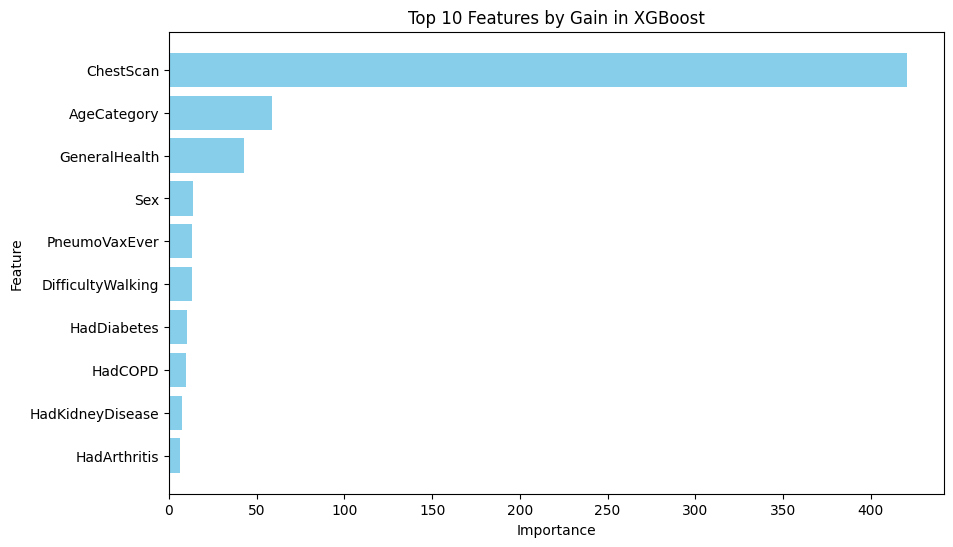

In [ ]:
# Get feature importances
importance_type = 'gain'
feature_importances = best_xgb.get_booster().get_score(importance_type=importance_type)

# Converting to a DataFrame for easier handling
importance_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])
importance_df['Importance'] = importance_df['Importance'].astype(float)

# Sorting by importance and selecting the top features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 10 Features by {importance_type.capitalize()} in XGBoost')
plt.gca().invert_yaxis()
plt.show()

## 2.2 XGBoost with PSO

Search Iteration 1/10 with params: num_particles=28, num_iterations=67, inertia_weight=0.9018756150843654, personal_coeff=2.431215401909255, social_coeff=1.6084985503897489, threshold=0.5825662672298328, batch_size=224
<class 'int'>
Search Iteration 2/10 with params: num_particles=38, num_iterations=65, inertia_weight=0.671125566907492, personal_coeff=1.5214683934457762, social_coeff=1.8118609073676482, threshold=0.3104672177263157, batch_size=176
<class 'int'>
Search Iteration 3/10 with params: num_particles=22, num_iterations=63, inertia_weight=0.6556268075961911, personal_coeff=1.9451446968707424, social_coeff=2.4713776603762954, threshold=0.4641923203735167, batch_size=237
<class 'int'>
Search Iteration 4/10 with params: num_particles=26, num_iterations=59, inertia_weight=0.7938928915053725, personal_coeff=1.5932382968478915, social_coeff=1.520202707481225, threshold=0.5968878701891541, batch_size=212
<class 'int'>
Search Iteration 5/10 with params: num_particles=40, num_iterations

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:09:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.76
Test Accuracy: 0.7649310101722228
Test AUC: 0.8447940926780393


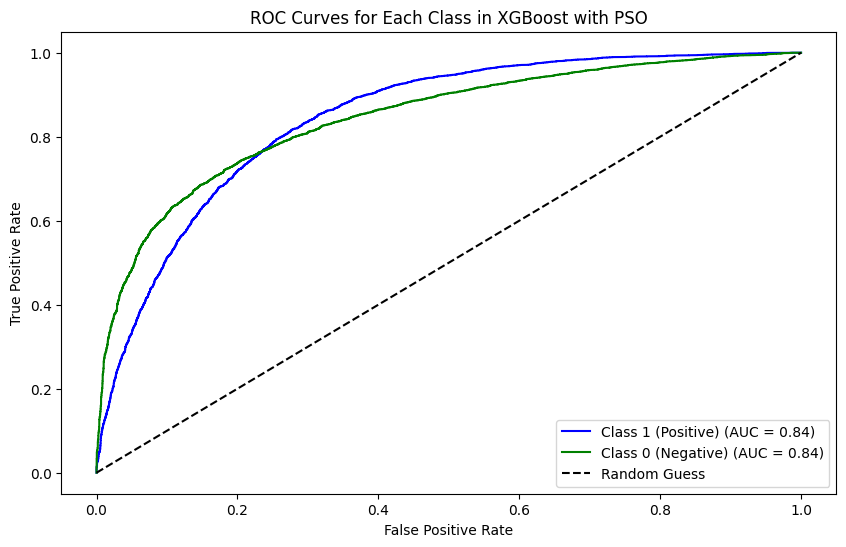

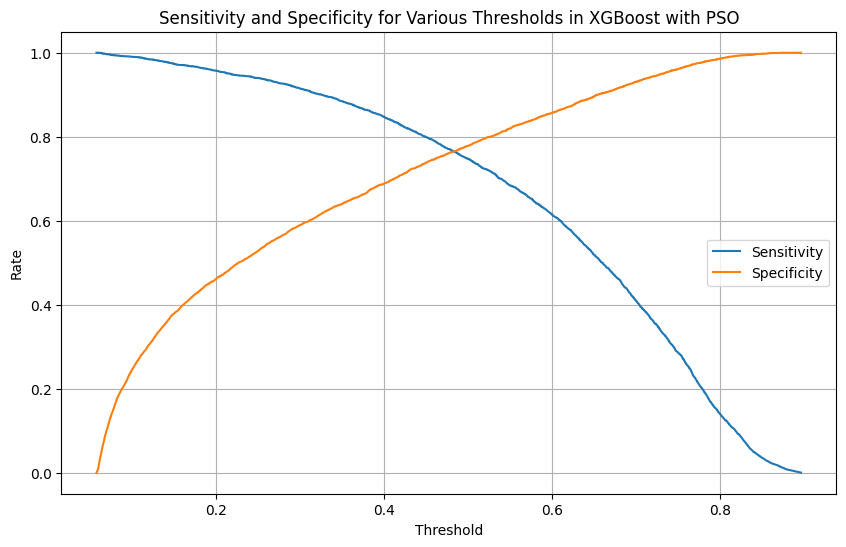


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      5606
           1       0.72      0.75      0.73      4323

    accuracy                           0.76      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.77      0.76      0.77      9929

Time elapsed: 337.21 seconds


In [ ]:
import time

best_position, best_score, best_params = random_search_pso(X, y,best_params_xgb, model_type='xgboost', search_iterations=10)

# Outputting the values based on selection criterion
print("==============================================================================")
print("Best PSO position (selected features):", best_position)
print("Best PSO score:", best_score)
print("Best PSO parameters:", best_params)
print("==============================================================================")

# PSO application
best_features, best_score = particle_swarm_optimization(X_train, y_train, 'xgboost', best_params['num_particles'],best_params['num_iterations'], best_params['inertia_weight'], best_params['personal_coeff'],best_params['social_coeff'], best_params_xgb,best_params['threshold'], best_params['batch_size'] )

# Retrieving selected feature data
X_FS_tuned=X_train.iloc[:,np.where(best_features >= 0.5)[0]]
X_test_FS_tuned=X_test.iloc[:,np.where(best_features >= 0.5)[0]]

print("==============================================================================")
print(X_FS_tuned.columns)
print(X_FS_tuned.head())
print("==============================================================================")

# Start the timer
start_time_xgb_PSO = time.time()

# XGBoostClassifier Initialisatoin
xgboost_PSO = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators= best_params_xgb['n_estimators'], max_depth = best_params_xgb['max_depth'], learning_rate=best_params_xgb['learning_rate'],
                            min_child_weight= best_params_xgb['min_child_weight'], subsample =best_params_xgb['subsample'], colsample_bytree = best_params_xgb['colsample_bytree'], gamma= best_params_xgb['gamma'], reg_alpha= best_params_xgb['reg_alpha'],
                            reg_lambda= best_params_xgb['reg_lambda'])

# Model training
xgboost_PSO.fit(X_FS_tuned, y_train)

# End the timer
end_time_xgb_PSO = time.time()

# Make predictions on the test set
y_pred_PSO = xgboost_PSO.predict(X_test_FS_tuned)

# Evaluate the model
accuracy_PSO = accuracy_score(y_test, y_pred_PSO)
print("==============================================================================")
print(f'Accuracy: {accuracy_PSO:.2f}')

# Check the performance of the model
print("Test Accuracy:", accuracy_score(y_test, y_pred_PSO))
print("Test AUC:", roc_auc_score(y_test, xgboost_PSO.predict_proba(X_test_FS_tuned)[:, 1]))
roc_auc(xgboost_PSO, X_test_FS_tuned, y_test, 'XGBoost with PSO')
analyze_thresholds(xgboost_PSO, X_test_FS_tuned, y_test, 'XGBoost with PSO')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_PSO))

# Calculate the elapsed time
elapsed_time_xgb_PSO = end_time_xgb_PSO - start_time_xgb_PSO
print(f"Time elapsed: {elapsed_time_xgb_PSO:.2f} seconds")

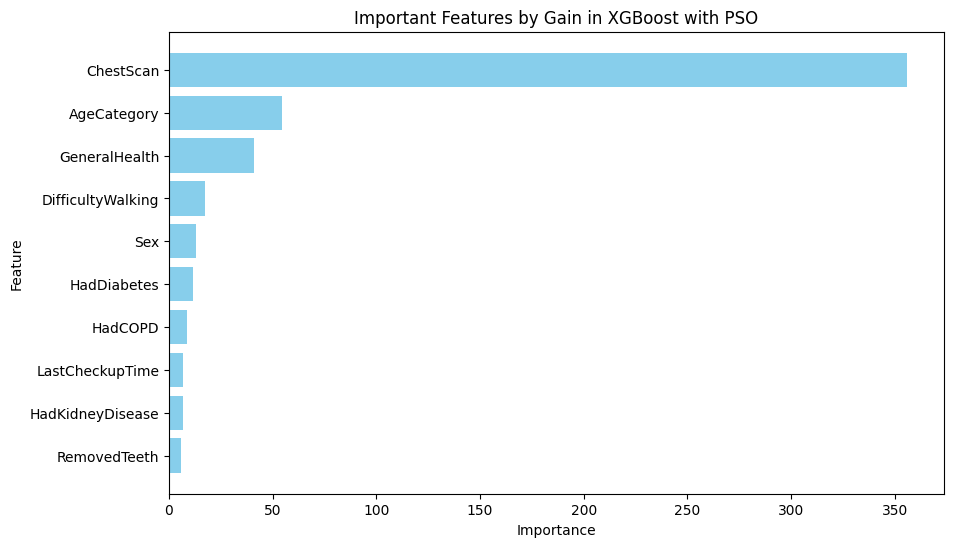

In [ ]:
# Get feature importances
importance_type = 'gain'
feature_importances = xgboost_PSO.get_booster().get_score(importance_type=importance_type)

# Converting to a DataFrame for easier handling
importance_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])
importance_df['Importance'] = importance_df['Importance'].astype(float)

# Sorting by importance and selecting the top features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Important Features by {importance_type.capitalize()} in XGBoost with PSO')
plt.gca().invert_yaxis()
plt.show()

# Support Vector Machine (SVM)

## 3.1 Standalone Support Vector Machine

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Test Accuracy: 0.7637224292476584
Test AUC: 0.8432746002865803


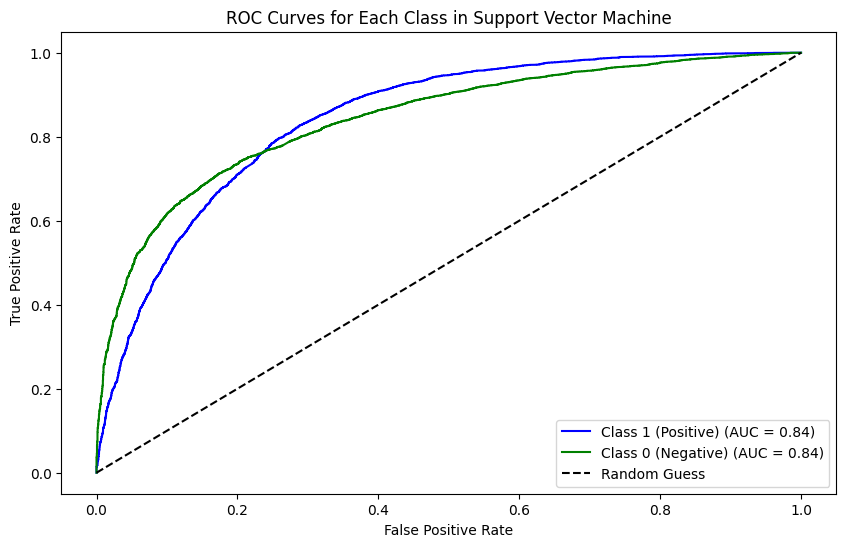

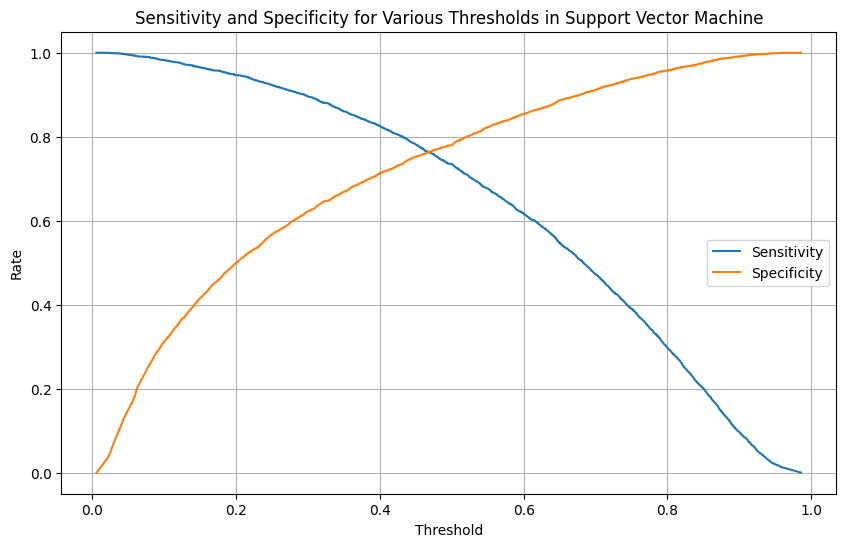


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      5606
           1       0.72      0.76      0.74      4323

    accuracy                           0.76      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.77      0.76      0.76      9929

Time elapsed: 1551.88 seconds


In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize SVC with probability=True for AUC calculation
svm = SVC(probability=True, random_state=42)

# Define the hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],             # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel type
    'gamma': ['scale', 0.01], # Kernel coefficient
}

# GridSearch
best_svm,best_params_svm=grid_search(X_train,y_train, param_grid, svm)

# Making predictions
predictions_svm = best_svm.predict(X_test)

# Checking the performance of the model
print("Test Accuracy:", accuracy_score(y_test, predictions_svm))
print("Test AUC:", roc_auc_score(y_test, best_svm.predict_proba(X_test)[:, 1]))
roc_auc(best_svm, X_test, y_test, 'Support Vector Machine')
analyze_thresholds(best_svm, X_test, y_test, 'Support Vector Machine')
print('\nClassification Report:')
print(classification_report(y_test, predictions_svm))

# Start the timer
start_time_svm_grid = time.time()

svc_model = SVC(kernel=best_params_svm['kernel'], random_state=42, class_weight="balanced",C=best_params_svm['C'], gamma=best_params_svm['gamma'], probability=True)
svc_model.fit(X_train,y_train)

# End the timer
end_time_svm_grid = time.time()

# Calculate the elapsed time
elapsed_time_svm_grid = end_time_svm_grid - start_time_svm_grid
print(f"Time elapsed: {elapsed_time_svm_grid:.2f} seconds")

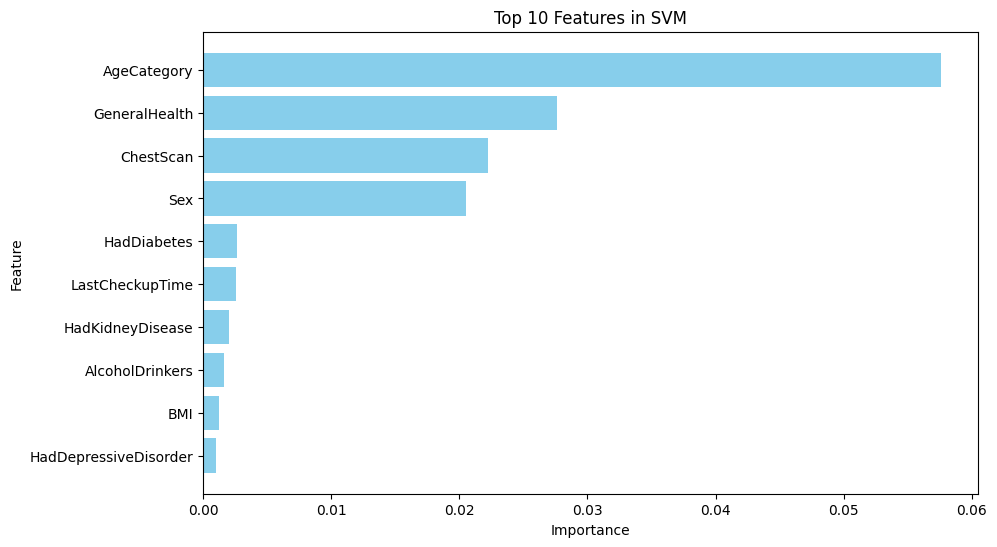

In [15]:
# Calculating permutation importance of features
perm_importance = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42)

# Creating a DataFrame for easy handling of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})

# Sorting by importance and selecting the top 10 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features in SVM')
plt.gca().invert_yaxis()
plt.show()

## 3.2 Support Vector Machine with PSO

Search Iteration 1/10 with params: num_particles=24, num_iterations=51, inertia_weight=0.8875626743248914, personal_coeff=1.733915712273764, social_coeff=2.069754927009459, threshold=0.6186349401663256, batch_size=186
<class 'int'>
Search Iteration 2/10 with params: num_particles=37, num_iterations=92, inertia_weight=0.5425441238721551, personal_coeff=1.5203174868244973, social_coeff=2.31495787661547, threshold=0.3229471317945176, batch_size=111
<class 'int'>
Search Iteration 3/10 with params: num_particles=47, num_iterations=91, inertia_weight=0.5112167068348786, personal_coeff=1.8467541497263644, social_coeff=2.4073636931753475, threshold=0.6445844804584286, batch_size=237
<class 'int'>
Search Iteration 4/10 with params: num_particles=46, num_iterations=50, inertia_weight=0.9694231557311026, personal_coeff=2.2775275709093483, social_coeff=2.153978675204594, threshold=0.30548726108833063, batch_size=153
<class 'int'>
Search Iteration 5/10 with params: num_particles=47, num_iterations=

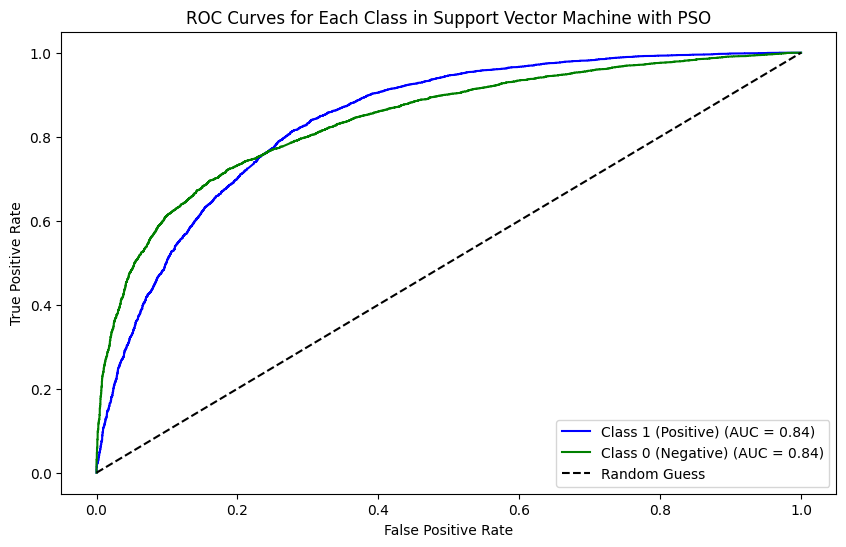

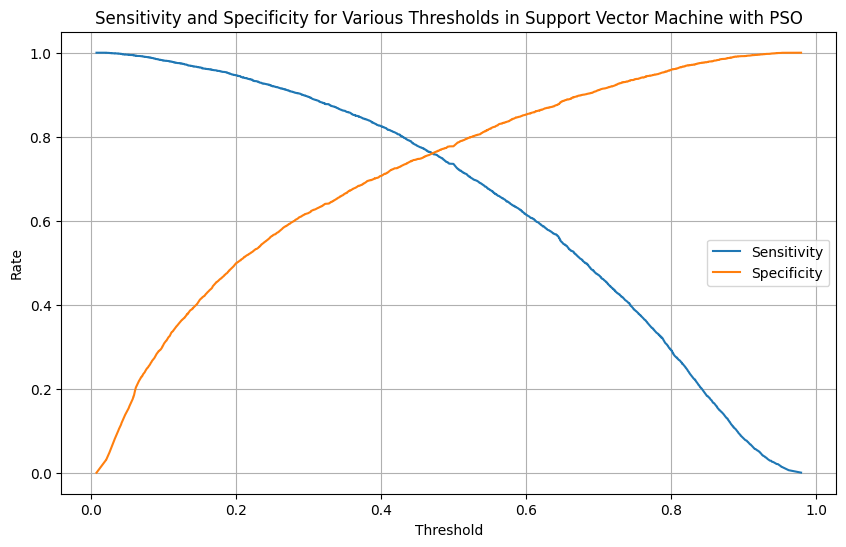


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      5606
           1       0.69      0.81      0.75      4323

    accuracy                           0.76      9929
   macro avg       0.76      0.77      0.76      9929
weighted avg       0.77      0.76      0.76      9929

Time elapsed: 959.11 seconds


In [21]:
# Performing random search on PSO for best parameter values
best_position, best_score, best_params = random_search_pso(X, y,best_params_svm,model_type="svm", search_iterations=10)

# Displaying best parameter values
print("Best PSO position:", best_position)
print("Best PSO score:", best_score)
print("Best PSO parameters:", best_params)

# PSO Initialisation for feature selection
best_features, best_score = particle_swarm_optimization(X_train, y_train, 'svm', best_params['num_particles'],best_params['num_iterations'], best_params['inertia_weight'], best_params['personal_coeff'],best_params['social_coeff'],best_params_svm,best_params['threshold'], best_params['batch_size'] )
print(f"Best feature subset: {np.where(best_features >=0.5)[0]}")
print(f"Best score: {best_score}")

# Retrieving identified feature data from the dataset
X_FS_tuned=X_train.iloc[:,np.where(best_features >= 0.5)[0]]
X_test_FS_tuned=X_test.iloc[:,np.where(best_features >= 0.5)[0]]
print(X_FS_tuned.columns)
print(X_FS_tuned.head())

# Start the timer
start_time_svm_PSO = time.time()

# Support Vector Machine Initialisation
svc_model_PSO = SVC(kernel=best_params_svm['kernel'], random_state=42, class_weight="balanced",C=best_params_svm['C'], gamma=best_params_svm['gamma'], probability=True)

# Train the model
svc_model_PSO.fit(X_FS_tuned, y_train)

# End the timer
end_time_svm_PSO = time.time()

# Make predictions on the test set
y_pred_svm_PSO = svc_model_PSO.predict(X_test_FS_tuned)

# Evaluate the model
accuracy_svm_PSO = accuracy_score(y_test, y_pred_svm_PSO)
print(f'Accuracy: {accuracy_svm_PSO:.2f}')

print("Test AUC:", roc_auc_score(y_test, svc_model_PSO.predict_proba(X_test_FS_tuned)[:, 1]))
roc_auc(svc_model_PSO, X_test_FS_tuned, y_test, 'Support Vector Machine with PSO')
analyze_thresholds(svc_model_PSO, X_test_FS_tuned, y_test, 'Support Vector Machine with PSO')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_svm_PSO))

# Calculate the elapsed time
elapsed_time_svm_PSO = end_time_svm_PSO - start_time_svm_PSO
print(f"Time elapsed: {elapsed_time_svm_PSO:.2f} seconds")

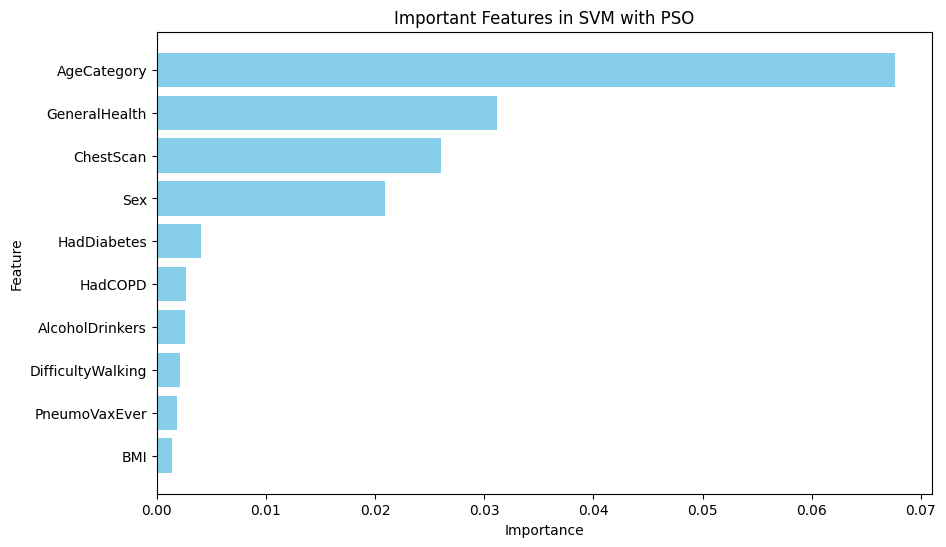

In [23]:
# Calculate permutation importance for features
perm_importance = permutation_importance(svc_model_PSO, X_test_FS_tuned, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': X_FS_tuned.columns, 'Importance': perm_importance.importances_mean})


# Sort by importance and select the top 10 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Important Features in SVM with PSO')
plt.gca().invert_yaxis()
plt.show()

# 4 Logistic Regression

## 4.1 Standalone Logistic Regression

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

Best Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Test Accuracy: 0.7619095578608117
Test AUC: 0.8432785615425261


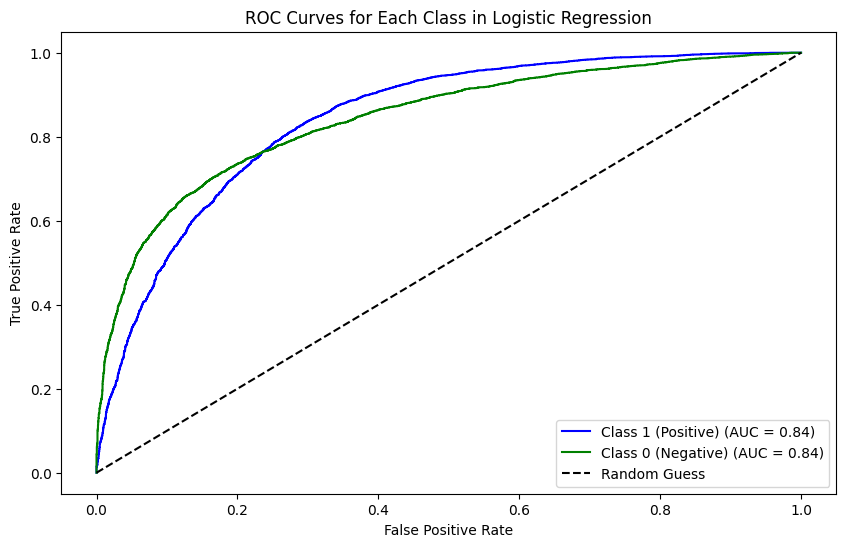

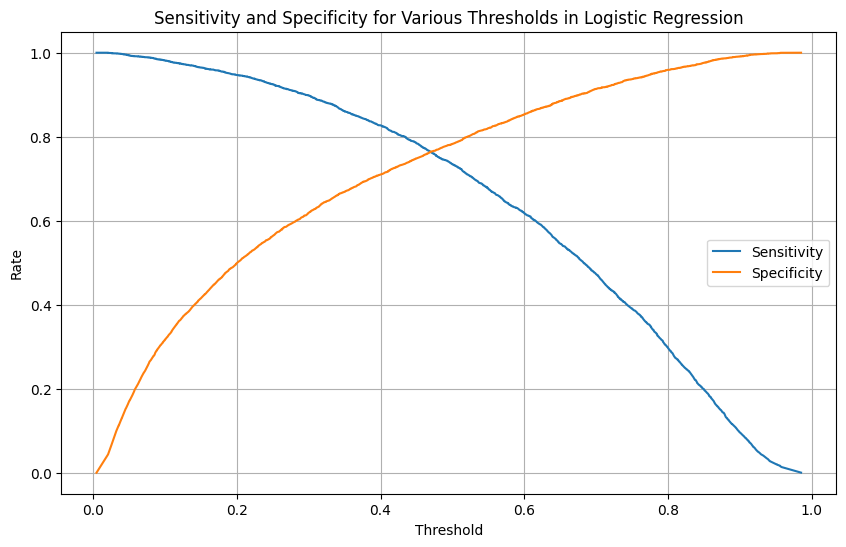


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      5606
           1       0.72      0.73      0.73      4323

    accuracy                           0.76      9929
   macro avg       0.76      0.76      0.76      9929
weighted avg       0.76      0.76      0.76      9929

Time elapsed: 0.07 seconds


In [14]:
# Initialize LogisticRegression
logreg = LogisticRegression(solver='liblinear', random_state=42)

# Define the hyperparameter grid for Logistic Regression
param_grid = {
    'solver': ['lbfgs', 'newton-cholesky', 'saga'],
    'C': [0.01, 0.1, 1, 10, 100],            # Inverse of regularization strength
    'penalty': ['l1', 'l2'],                 # Regularization type (L1 or L2)
    'class_weight': [None, 'balanced']       # Adjust weights inversely proportional to class frequencies
}

# Initialize GridSearchCV
best_logreg,best_params_logreg  = grid_search(X_train,y_train, param_grid, logreg)

# Make predictions
predictions_logreg = best_logreg.predict(X_test)

# Check the performance of the model
print("Test Accuracy:", accuracy_score(y_test, predictions_logreg))
print("Test AUC:", roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1]))
roc_auc(best_logreg, X_test, y_test, 'Logistic Regression')
analyze_thresholds(best_logreg, X_test, y_test, 'Logistic Regression')
print('\nClassification Report:')
print(classification_report(y_test, predictions_logreg))

# Start the timer
start_time_logreg_grid = time.time()

log_reg = LogisticRegression(solver=best_params_logreg['solver'],C=best_params_logreg['C'], penalty=best_params_logreg['penalty'], class_weight=best_params_logreg['class_weight'])
log_reg.fit(X_train, y_train)

# End the timer
end_time_logreg_grid = time.time()

# Calculate the elapsed time
elapsed_time_logreg_grid = end_time_logreg_grid - start_time_logreg_grid
print(f"Time elapsed: {elapsed_time_logreg_grid:.2f} seconds")

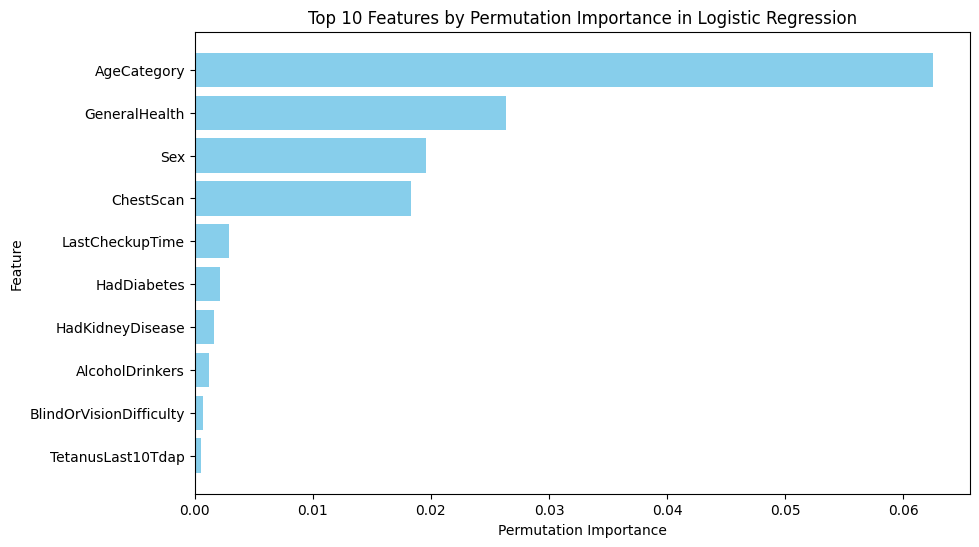

In [11]:
# Calculate permutation importance
perm_importance = permutation_importance(best_logreg, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})

# Sort by importance and select the top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Permutation Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

## 4.2 Logistic Regression with PSO

Search Iteration 1/10 with params: num_particles=11, num_iterations=52, inertia_weight=0.8050461189754147, personal_coeff=1.5178137585082023, social_coeff=2.3825571899253224, threshold=0.49987352656035605, batch_size=160
<class 'int'>
Search Iteration 2/10 with params: num_particles=43, num_iterations=53, inertia_weight=0.9587884613238669, personal_coeff=2.228017848533342, social_coeff=1.5775411751832165, threshold=0.5149257759759753, batch_size=181
<class 'int'>
Search Iteration 3/10 with params: num_particles=39, num_iterations=54, inertia_weight=0.7336818326695425, personal_coeff=2.441730414801685, social_coeff=1.5909334265876809, threshold=0.6597612780204269, batch_size=253
<class 'int'>
Search Iteration 4/10 with params: num_particles=49, num_iterations=73, inertia_weight=0.7476938830388582, personal_coeff=1.797227051683373, social_coeff=2.226148429390896, threshold=0.6244087645148022, batch_size=241
<class 'int'>
Search Iteration 5/10 with params: num_particles=45, num_iterations

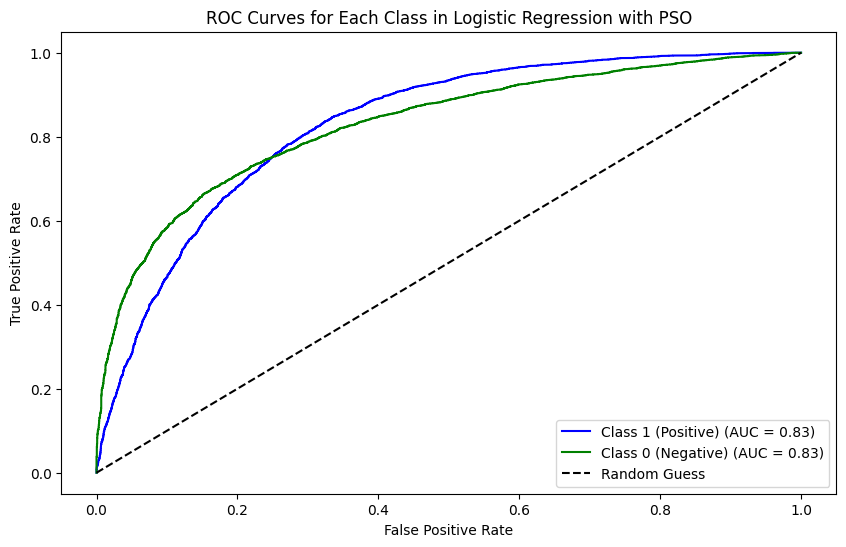

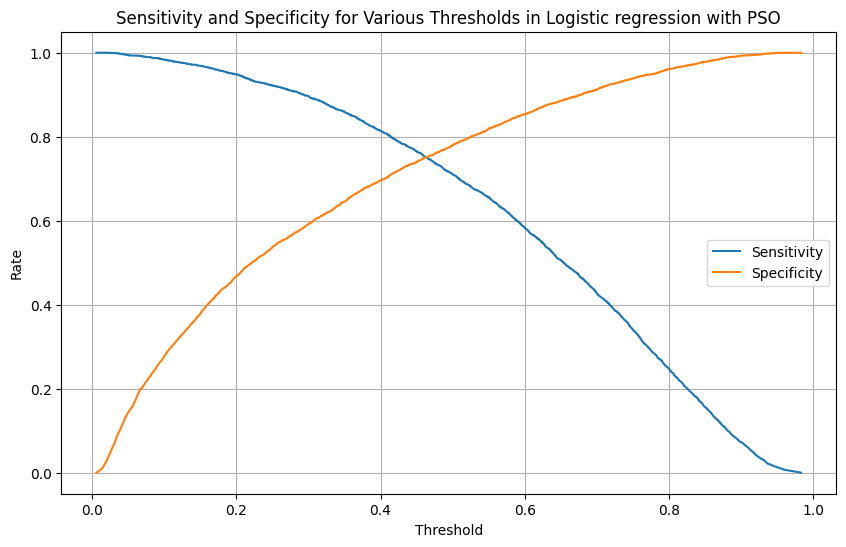


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5606
           1       0.71      0.71      0.71      4323

    accuracy                           0.75      9929
   macro avg       0.75      0.75      0.75      9929
weighted avg       0.75      0.75      0.75      9929

Time elapsed: 0.04 seconds


In [16]:
from sklearn.metrics import r2_score

# Performing random search on PSO for best parameter values
best_position, best_score, best_params = random_search_pso(X, y,best_params_logreg, model_type='logistic_regression', search_iterations=10)

# Displaying best PSO values
print("Best PSO position (selected features):", best_position)
print("Best PSO score:", best_score)
print("Best PSO parameters:", best_params)

# Initialising PSO for feature selection
best_features, best_score = particle_swarm_optimization(X_train, y_train, 'logistic_regression', best_params['num_particles'],best_params['num_iterations'], best_params['inertia_weight'], best_params['personal_coeff'],best_params['social_coeff'],best_params_logreg,best_params['threshold'], best_params['batch_size'] )

# Retreiving feature data from the dataset
X_FS_tuned=X_train.iloc[:,np.where(best_features >= 0.5)[0]]
X_test_FS_tuned=X_test.iloc[:,np.where(best_features >= 0.5)[0]]
print(X_FS_tuned.columns)
print(len(X_FS_tuned.columns))
print(X_FS_tuned.head())

# Start the timer
start_time_lr_PSO = time.time()

# Initialize the RandomForestClassifier
reg_PSO = LogisticRegression(solver=best_params_logreg['solver'],C=best_params_logreg['C'], penalty=best_params_logreg['penalty'], class_weight=best_params_logreg['class_weight'])

# Train the model
reg_PSO.fit(X_FS_tuned, y_train)

# End the timer
end_time_lr_PSO = time.time()

# Make predictions on the test set
y_pred_lr_PSO = reg_PSO.predict(X_test_FS_tuned)

# Checking the model performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_lr_PSO))
print("Test AUC:", roc_auc_score(y_test, reg_PSO.predict_proba(X_test_FS_tuned)[:, 1]))

roc_auc(reg_PSO, X_test_FS_tuned, y_test, 'Logistic Regression with PSO')
analyze_thresholds(reg_PSO, X_test_FS_tuned, y_test, 'Logistic regression with PSO')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr_PSO))

# Calculate the elapsed time
elapsed_time_lr_PSO = end_time_lr_PSO - start_time_lr_PSO
print(f"Time elapsed: {elapsed_time_lr_PSO:.2f} seconds")

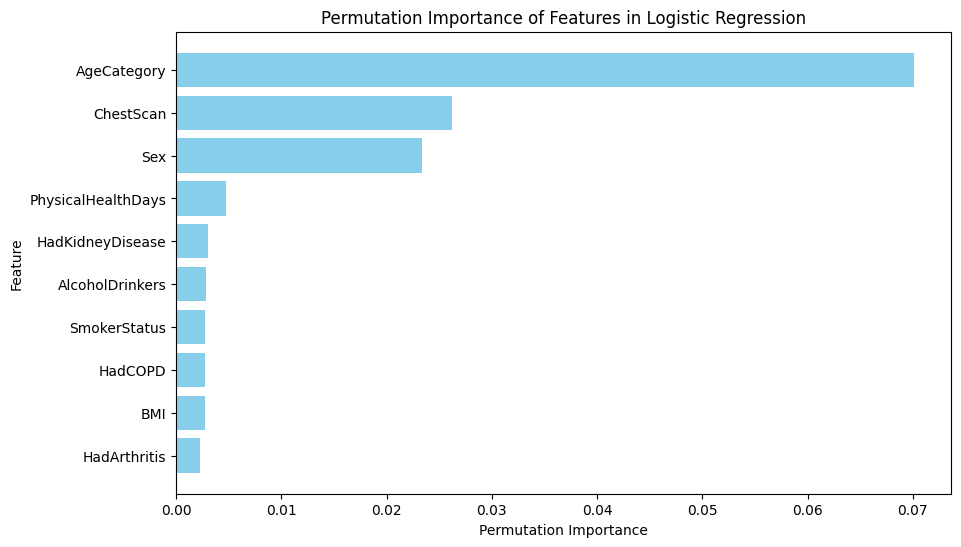

In [14]:
# Calculate permutation importance of features
perm_importance = permutation_importance(reg_PSO, X_test_FS_tuned, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
importance_df = pd.DataFrame({'Feature': X_FS_tuned.columns, 'Importance': perm_importance.importances_mean})

# Sort by importance and select the top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance of Features in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

# Time Variance analysis

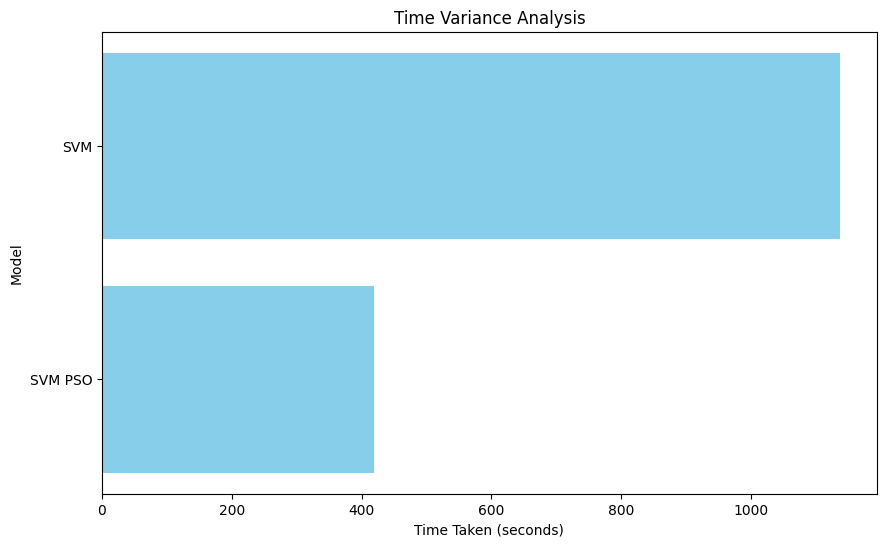

In [30]:

 # Seperating SVM as it took longer time to train
model_time_analysis = pd.DataFrame({
    'model': [ 'SVM', 'SVM PSO'],
    'time': [elapsed_time_svm_grid, elapsed_time_svm_PSO]
})

# Plotting the time variance for SVM
plt.figure(figsize=(10, 6))
plt.barh(model_time_analysis['model'], model_time_analysis['time'], color='skyblue')
plt.xlabel('Time Taken (seconds)')
plt.ylabel('Model')
plt.title('Time Variance Analysis')
plt.gca().invert_yaxis()
plt.show()

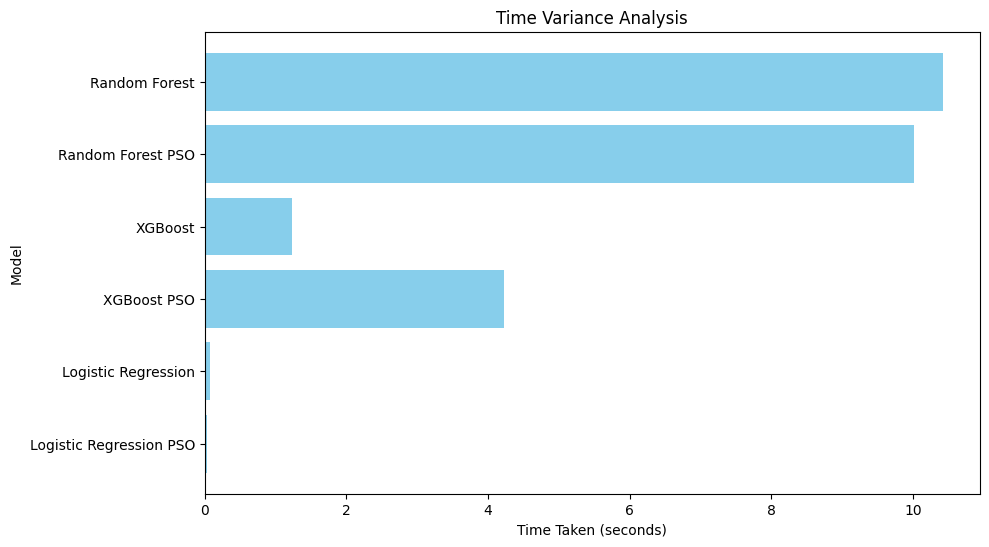

In [29]:
 # Seperating the other six models
model_time_analysis = pd.DataFrame({
    'model': ['Random Forest', 'Random Forest PSO', 'XGBoost', 'XGBoost PSO', 'Logistic Regression', 'Logistic Regression PSO'],
    'time': [elapsed_time_rf, elapsed_time_rf_PSO, elapsed_time_xgb_grid, elapsed_time_xgb_PSO,
             elapsed_time_logreg_grid, elapsed_time_lr_PSO]
})

# Plotting the time variance for SVM
plt.figure(figsize=(10, 6))
plt.barh(model_time_analysis['model'], model_time_analysis['time'], color='skyblue')
plt.xlabel('Time Taken (seconds)')
plt.ylabel('Model')
plt.title('Time Variance Analysis')
plt.gca().invert_yaxis()
plt.show()